## __Vector Quantized Variational AutoEncoder (VQ-VAE)__ Modelling

Source: [Neural Discrete Representation Learning](https://proceedings.neurips.cc/paper/2017/hash/7a98af17e63a0ac09ce2e96d03992fbc-Abstract.html)

In [2]:
import torch
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import matplotlib.pyplot as plt
from torchvision import datasets
from torch.utils.data import DataLoader
from torchvision.utils import make_grid
from torchvision.transforms import v2
from torchinfo import summary

### __VQ-VAE Architecture__

VQ_VAE uses __discrete latent variable__ instead of continuous to pass into decoder of the network.

At first, we define a latent embedding space $e\in \mathbb{R}^{k\times D}$ where $K$ is the size of discrete latent space and $D$ is the dimension of each latent embedding vector.

- Model takes the input $x$ and encoder output $z_{e}(x)$
- __Discrete latent variable (z)__ are then calculated by nearest neighbour look up from the shared embedding space, $e$ as given below:

$$
q(z=k \mid x) =
\begin{cases}
1 & \text{if } k = \arg\min_j \| z_e(x) - e_j \|_2 \\
0 & \text{otherwise}
\end{cases}$$

- The encoder output of $z_{e}(x)$ is replaced by nearest embedding vector $e_{k}$
- This makes posterior $q(z |x)$ a one-hot categorical distribution, and these embedding are then used as an input in decoder network.

This is the __Vector Quantization__ process and quantized version of decoder input of $z_{e}(x)$ - $z_{q}(x)$ is given by:

$$ z_{q}(x) = e_{k} \quad \text{where} \quad
k = \arg\min_j \| z_e(x) - e_j \|_2 $$



### __Training Part__

During the forward pass, the nearest embedding $z_{q}(x)$ is passed to the decoder, and during the backwards pass the gradient $∇_{z}L$ is passed unaltered to the encoder.

In [ ]:
transform = v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])

train_data = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_data = datasets.MNIST(root='./data', train=False, download=True, transform=transform)


batch_size = 128
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

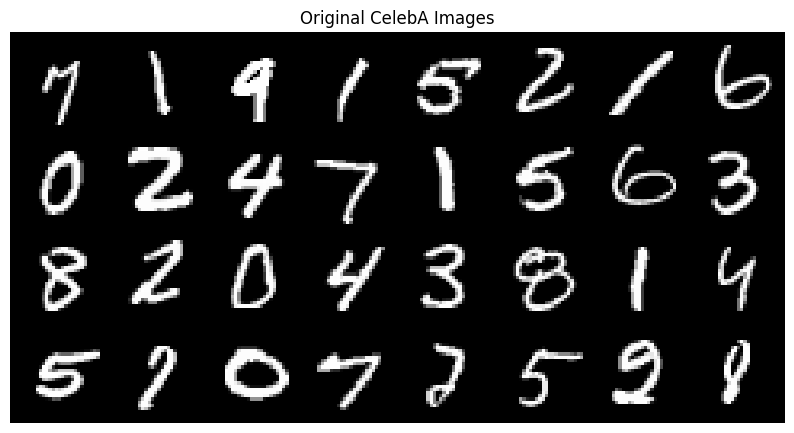

In [4]:
def show_images(images, title=None, nrow=8):
    grid = make_grid(images, nrow=nrow, padding=2)
    plt.figure(figsize=(10,10))
    plt.imshow(np.transpose(grid, (1,2,0))) # changing order of grid to (H, W, C)
    if title:
        plt.title(title)
    plt.axis('off')
    plt.show()

# Getting new batch of training celeba data
dataiter = iter(train_loader)
images, _ = next(dataiter)

# Plotting images
show_images(images[:32], "Original CelebA Images")

In [5]:
class VectorQuantizer(nn.Module):

    def __init__(self, num_embeddings, embedding_dim, commitment_cost=0.2):
        super().__init__()
        self.num_embeddings = num_embeddings
        self.embedding_dim = embedding_dim
        self.commitment_cost = commitment_cost

        self.embedding = nn.Embedding(num_embeddings, embedding_dim)
        self.embedding.weight.data.uniform_(-1/num_embeddings, 1/num_embeddings)

    def forward(self, x):
        # x shape: (B, C, H, W) → reshape to (B*H*W, C)
        flat_x = x.permute(0, 2, 3, 1).contiguous()
        flat_x = flat_x.view(-1, self.embedding_dim)

        # Compute distances
        distances = (
            torch.sum(flat_x**2, dim=1, keepdim=True) +
            torch.sum(self.embedding.weight**2, dim=1) -
            2 * torch.matmul(flat_x, self.embedding.weight.t()))

        encoding_indices = torch.argmin(distances, dim=1)
        quantized = self.embedding(encoding_indices)

        quantized = quantized.view(x.shape[0], x.shape[2], x.shape[3], -1).permute(0, 3, 1, 2)
        quantized = x + (quantized - x).detach()

        # Losses
        codebook_loss = F.mse_loss(quantized.detach(), x)
        commitment_loss = F.mse_loss(x.detach(), quantized)
        vq_loss = codebook_loss + self.commitment_cost * commitment_loss

        # Return quantized, vq_loss, and encoding_indices
        return quantized, vq_loss, encoding_indices.view(x.shape[0], -1)

In [6]:
class VQVAE(nn.Module):
    def __init__(self, num_embeddings=128, embedding_dim=32, commitment_cost=0.2):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 64, 4, stride=2, padding=1),
            nn.LeakyReLU(),
            nn.Conv2d(64, 128, 4, stride=2, padding=1),
            nn.LeakyReLU(),
            nn.Conv2d(128, embedding_dim, 1)
        )

        self.vq = VectorQuantizer(num_embeddings, embedding_dim, commitment_cost)

        self.decoder = nn.Sequential(
         
            nn.ConvTranspose2d(embedding_dim, 128, 4, stride=2, padding=1),
            nn.LeakyReLU(),
            nn.ConvTranspose2d(128, 64, 4, stride=2, padding=1),
            nn.LeakyReLU(),
            nn.Conv2d(64, 1, 3, padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        z = self.encoder(x)
        quantized, vq_loss, encoding_indices = self.vq(z)
        x_recon = self.decoder(quantized)
        return x_recon, vq_loss, encoding_indices

    def decode_from_indices(self, indices):
        # Convert indices to quantized vectors
        quantized = self.vq.embedding(indices)
        # Reshape to (B, H, W, C) then permute to (B, C, H, W)
        quantized = quantized.view(indices.shape[0], 8, 8, -1).permute(0, 3, 1, 2)
        return self.decoder(quantized)

In [ ]:
num_epochs = 30
learning_rate = 25e-4

# Define model, optimizer, and device
model = VQVAE(num_embeddings=64, embedding_dim=16)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [8]:
print(summary(model, input_size=(1, 1, 28, 28)))

Layer (type:depth-idx)                   Output Shape              Param #
VQVAE                                    [1, 1, 28, 28]            --
├─Sequential: 1-1                        [1, 16, 7, 7]             --
│    └─Conv2d: 2-1                       [1, 64, 14, 14]           1,088
│    └─LeakyReLU: 2-2                    [1, 64, 14, 14]           --
│    └─Conv2d: 2-3                       [1, 128, 7, 7]            131,200
│    └─LeakyReLU: 2-4                    [1, 128, 7, 7]            --
│    └─Conv2d: 2-5                       [1, 16, 7, 7]             2,064
├─VectorQuantizer: 1-2                   [1, 16, 7, 7]             --
│    └─Embedding: 2-6                    [49, 16]                  1,024
├─Sequential: 1-3                        [1, 1, 28, 28]            --
│    └─ConvTranspose2d: 2-7              [1, 128, 14, 14]          32,896
│    └─LeakyReLU: 2-8                    [1, 128, 14, 14]          --
│    └─ConvTranspose2d: 2-9              [1, 64, 28, 28]           

In [9]:
#training loop
import time
from tqdm import tqdm
start = time.perf_counter()
def train(epoch):

  model.train()
  accumulated_recon_loss = 0
  accumulated_vq_loss = 0
  training_loss = 0

  for batch_idx, (data, _) in enumerate(tqdm(train_loader)):

    optimizer.zero_grad()
    recon_batch, vq_loss, _ = model(data)

    recon_loss = F.binary_cross_entropy(recon_batch, data, reduction='mean')
    total_loss = recon_loss + vq_loss

    total_loss.backward()
    training_loss += total_loss.item()
    accumulated_recon_loss += recon_loss.item()
    accumulated_vq_loss += vq_loss.item()
    optimizer.step()

  print(f'Epoch: {epoch} Total Loss: {training_loss / len(train_loader.dataset):.4f} '
          f'Reconstruction Loss: {accumulated_recon_loss / len(train_loader.dataset):.4f} '
          f'VQ Loss: {accumulated_vq_loss / len(train_loader.dataset):.4f}')

for epoch in range(1, num_epochs + 1):
  train(epoch)

end = time.perf_counter()
s2mps = lambda s: f"{s // 60:.0f} min {s % 60:.2f} s"
print(f"Total Training Time: {s2mps(end - start)}")

100%|██████████| 1875/1875 [02:23<00:00, 13.05it/s]


Epoch: 1 Total Loss: 1.6327 Reconstruction Loss: 0.0033 VQ Loss: 1.6293


100%|██████████| 1875/1875 [02:49<00:00, 11.08it/s]


Epoch: 2 Total Loss: 2.1669 Reconstruction Loss: 0.0027 VQ Loss: 2.1642


100%|██████████| 1875/1875 [02:32<00:00, 12.32it/s]


Epoch: 3 Total Loss: 2.0464 Reconstruction Loss: 0.0026 VQ Loss: 2.0438


100%|██████████| 1875/1875 [02:26<00:00, 12.77it/s]


Epoch: 4 Total Loss: 1.9357 Reconstruction Loss: 0.0026 VQ Loss: 1.9331


100%|██████████| 1875/1875 [02:09<00:00, 14.52it/s]


Epoch: 5 Total Loss: 1.8177 Reconstruction Loss: 0.0025 VQ Loss: 1.8152


100%|██████████| 1875/1875 [02:08<00:00, 14.54it/s]


Epoch: 6 Total Loss: 1.7565 Reconstruction Loss: 0.0025 VQ Loss: 1.7540


100%|██████████| 1875/1875 [02:23<00:00, 13.09it/s]


Epoch: 7 Total Loss: 1.7058 Reconstruction Loss: 0.0025 VQ Loss: 1.7033


100%|██████████| 1875/1875 [04:29<00:00,  6.95it/s]


Epoch: 8 Total Loss: 1.6488 Reconstruction Loss: 0.0025 VQ Loss: 1.6464


100%|██████████| 1875/1875 [03:29<00:00,  8.97it/s]


Epoch: 9 Total Loss: 1.6260 Reconstruction Loss: 0.0024 VQ Loss: 1.6236


100%|██████████| 1875/1875 [02:02<00:00, 15.28it/s]

Epoch: 10 Total Loss: 1.5880 Reconstruction Loss: 0.0024 VQ Loss: 1.5856
Total Training Time: 26 min 54.95 s


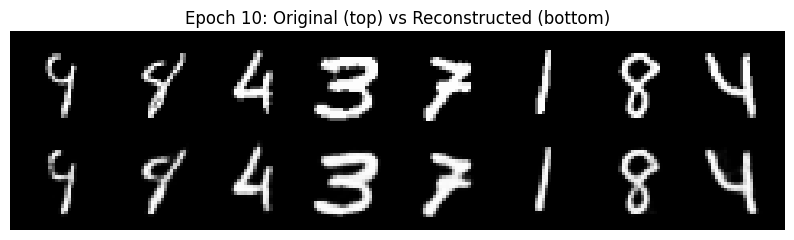

In [12]:
# reconstructing some images after last epoch
model.eval()
with torch.no_grad():

  sample = images[:8]
  recon, _, _ = model(sample)
  comparison = torch.cat([sample, recon])
  show_images(comparison, f'Epoch {epoch}: Original (top) vs Reconstructed (bottom)')

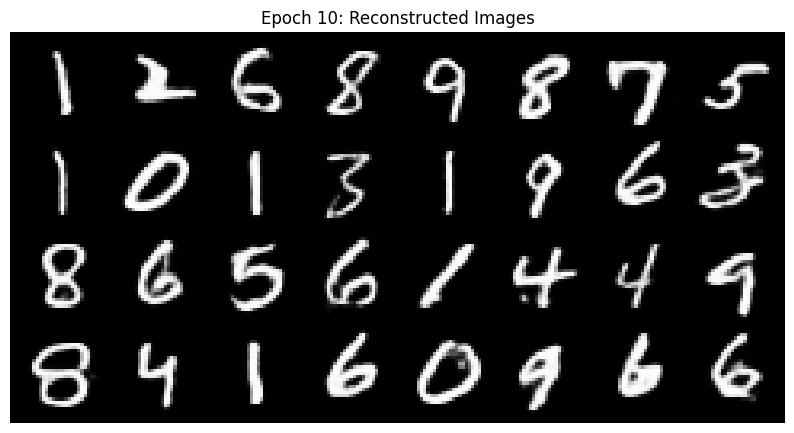

In [13]:
# displaying only reconstructed images
model.eval()
with torch.no_grad():
  dataiter = iter(train_loader)
  images, _ = next(dataiter)

  sample = images[:32] 
  recon, _, _ = model(sample)

  show_images(recon.cpu(), f'Epoch {epoch}: Reconstructed Images')